In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/DATA/Question_Duplicates_Dataset")
!ls

Mounted at /content/drive
model.png  Quora_question_pairs_test.csv  Quora_question_pairs_train.csv


# Loading Data

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('Quora_question_pairs_train.csv', index_col=False)

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.shape

(404290, 6)

In [6]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [7]:
df = df.drop(['id','qid1','qid2'],axis=1)

# Text Preprocessing 

In [8]:
import string
import re
import os
import nltk
#nltk.download('stopwords')
nltk.download('punkt')
#from nltk.corpus import stopwords
#stopwords_english = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                       "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                       "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       'i\'m':'i am', "i've": "i have", "isn't": "is not", "it'd": "it would", 
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                       "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                       "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                       'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
                       'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled'}

In [10]:
def process_text(text):
    '''
    Input: 
        text: a string containing a text
    Output:
        text_clean: a list of words containing the processed text
    
    '''
    # remove number 
    text = re.sub('[0-9]', '', text)
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    # remove the dates like Mar 30 2013
    text = re.sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', text)
    text = re.sub(r"[/(){}\[\]\|,;.:\?\-\'\"$^]", '', text)
 
    #text = " ".join(word for word in text.split() if word not in stopwords_english)
    
    ##clean contractions
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else contraction_mapping[t.lower()] if t.lower() in contraction_mapping else t for t in text.split(" ")])
     

    return  text

In [11]:
df['q1'] = df['question1'].apply(str).apply(process_text)
df['q2'] = df['question2'].apply(str).apply(process_text)


In [12]:
df.head()

,question1,question2,is_duplicate,q1,q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when mathmath is divided by
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water


In [13]:
df = df.drop(['question1','question2'],axis=1)

In [14]:
df.head()

,is_duplicate,q1,q2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...
2,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,0,Why am I mentally very lonely How can I solve it,Find the remainder when mathmath is divided by
4,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water


# Data Preparation for Bert

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['q1','q2']], df['is_duplicate'].values, 
                                                    random_state=33, test_size = 0.3)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(283003, 2) (121287, 2)
(283003,) (121287,)


In [16]:
def convert_to_transformer_inputs(df, columns, tokenizer, max_sequence_length):

    def return_id(str, max_sequence_length):

       inputs = tokenizer.encode_plus(str,
            add_special_tokens=True,
            max_length=max_sequence_length)
        
       input_ids =  inputs["input_ids"]
       input_masks = [1] * len(input_ids)
       input_segments = inputs["token_type_ids"]
        
       padding_length = max_sequence_length - len(input_ids)
       padding_id = tokenizer.pad_token_id
        
       input_ids = input_ids + ([padding_id] * padding_length)
       input_masks = input_masks + ([0] * padding_length)
       input_segments = input_segments + ([0] * padding_length)
        
       return [input_ids, input_masks, input_segments]
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []

    for _, instance in tqdm(df[columns].iterrows(), total=len(df)):
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1 = return_id(str1, max_sequence_length)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        ids_2, masks_2, segments_2 = return_id(str2, max_sequence_length)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
        
    return [np.asarray(input_ids_1, dtype=np.int32), 
            np.asarray(input_masks_1, dtype=np.int32), 
            np.asarray(input_segments_1, dtype=np.int32),
            np.asarray(input_ids_2, dtype=np.int32), 
            np.asarray(input_masks_2, dtype=np.int32), 
            np.asarray(input_segments_2, dtype=np.int32)]


# SIAMESE BERT

In [17]:
!pip install transformers
from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')
from tqdm.notebook import tqdm

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 901kB 54.1MB/s 
     |████████████████████████████████| 3.3MB 52.0MB/s 


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
max_sequence_length = 50 
input_train = convert_to_transformer_inputs(X_train, ['q1','q2'], tokenizer, max_sequence_length)
input_test = convert_to_transformer_inputs(X_test, ['q1','q2'], tokenizer, max_sequence_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [19]:
input_train[0].shape

(283003, 50)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [21]:
def siamese_bert():
        
    id1 = Input((max_sequence_length,), dtype=tf.int32)
    id2 = Input((max_sequence_length,), dtype=tf.int32)
    
    mask1 = Input((max_sequence_length,), dtype=tf.int32)
    mask2 = Input((max_sequence_length,), dtype=tf.int32)
    
    atn1 = Input((max_sequence_length,), dtype=tf.int32)
    atn2 = Input((max_sequence_length,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding1 = bert_model(id1, attention_mask=mask1, token_type_ids=atn1)[0]
    embedding2 = bert_model(id2, attention_mask=mask2, token_type_ids=atn2)[0]
    
    x1 = GlobalAveragePooling1D()(embedding1)
    x2 = GlobalAveragePooling1D()(embedding2)
    
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[id1, mask1, atn1, id2, mask2, atn2], outputs=out)
    
    return model

In [22]:
model = siamese_bert()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

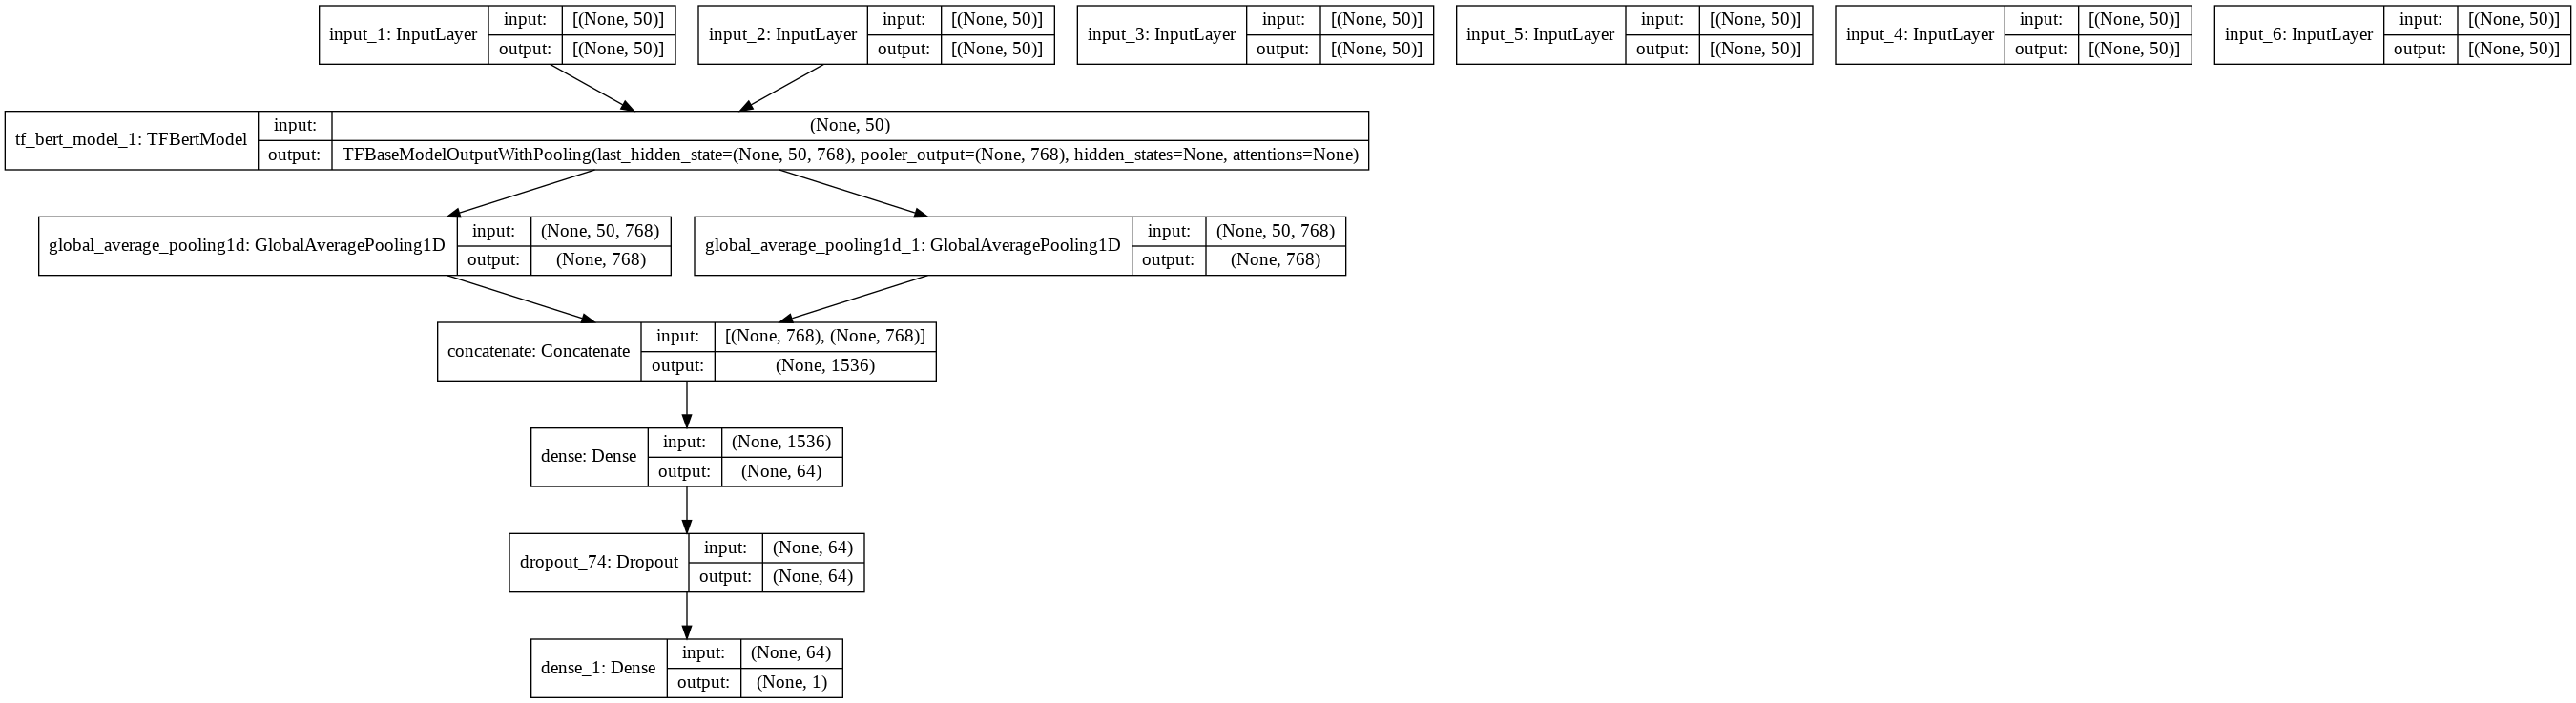

In [23]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names= True)

In [24]:
optimizer = Adam(
    learning_rate=5e-05,  
    epsilon=1e-08,
    decay=0.001,
    clipnorm=1.0)

loss = tf.keras.losses.BinaryCrossentropy()

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics=['acc'])

In [25]:
model.fit(input_train, y_train, epochs=10, batch_size=64, validation_data=(input_test, y_test))

Epoch 1/10
4422/4422 [==============================] - 2035s 453ms/step - loss: 0.5158 - acc: 0.7441 - val_loss: 0.4616 - val_acc: 0.7765
Epoch 2/10
4422/4422 [==============================] - 1998s 452ms/step - loss: 0.4291 - acc: 0.7981 - val_loss: 0.4417 - val_acc: 0.7897
Epoch 3/10
4422/4422 [==============================] - 2000s 452ms/step - loss: 0.3875 - acc: 0.8212 - val_loss: 0.4378 - val_acc: 0.7962
Epoch 4/10
4422/4422 [==============================] - 2001s 452ms/step - loss: 0.3616 - acc: 0.8352 - val_loss: 0.4474 - val_acc: 0.7985
Epoch 5/10
4422/4422 [==============================] - 2001s 452ms/step - loss: 0.3410 - acc: 0.8459 - val_loss: 0.4542 - val_acc: 0.8002
Epoch 6/10
4422/4422 [==============================] - 2001s 452ms/step - loss: 0.3273 - acc: 0.8533 - val_loss: 0.4481 - val_acc: 0.8043
Epoch 7/10
4422/4422 [==============================] - 2000s 452ms/step - loss: 0.3152 - acc: 0.8596 - val_loss: 0.4461 - val_acc: 0.8056
Epoch 8/10
4422/4422 [=====

In [26]:
model.save("Model_question_duplicates_BERT")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: Model_question_duplicates_BERT/assets


INFO:tensorflow:Assets written to: Model_question_duplicates_BERT/assets


In [27]:
model.load_weights("Model_question_duplicates_BERT")

# Testing own sentences

In [46]:
input_str_1 = X_test.iloc[2]['q1']
input_str_2 = X_test.iloc[2]['q2']
df = pd.DataFrame({'q1': [input_str_1] ,
                   'q2': [input_str_2] })

max_sequence_length = 50 
test = convert_to_transformer_inputs(df, ['q1','q2'], tokenizer, max_sequence_length)
prob = model.predict(test)
print("questions [{}] and [{}] are {} with score {}".format(input_str_1, input_str_2, 'similar' if prob > 0.5 else 'not similar', prob))


questions [Is Harry Potter really the Chosen One] and [Other than harry potter who was the chosen one and why] are similar with score [[0.89353704]]
